<a href="https://colab.research.google.com/github/PATELOM925/Automated_Sleep_Staging_Techniques/blob/main/5CLASS_40_SUBJECTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

if torch.cuda.is_available():
    print('CUDA-enabled GPU found.')
else:
    print('No GPU found. Training will be carried out on CPU, which might be '
          'slower.\n\nIf running on Google Colab, you can request a GPU runtime by'
          ' clicking\n`Runtime/Change runtime type` in the top bar menu, then '
          'selecting \'GPU\'\nunder \'Hardware accelerator\'.')


CUDA-enabled GPU found.


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import os

base_dir = '/content/drive/MyDrive/sleepData/sleep_data/'
all_files = os.listdir(base_dir)

psg_files = sorted([f for f in all_files if 'PSG.edf' in f])[:20]
hypnogram_files = sorted([f for f in all_files if 'Hypnogram.edf' in f])[:20]

fnames = [(os.path.join(base_dir, psg), os.path.join(base_dir, hypnogram))
          for psg, hypnogram in zip(psg_files, hypnogram_files)]

for psg, hypnogram in fnames:
    print(f"PSG: {psg}, Hypnogram: {hypnogram}")


PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4001E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4001EC-Hypnogram.edf
PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4002E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4002EC-Hypnogram.edf
PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4011E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4011EH-Hypnogram.edf
PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4012E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4012EC-Hypnogram.edf
PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4021E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4021EH-Hypnogram.edf
PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4022E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4022EJ-Hypnogram.edf
PSG: /content/drive/MyDrive/sleepData/sleep_data/SC4031E0-PSG.edf, Hypnogram: /content/drive/MyDrive/sleepData/sleep_data/SC4031EC

In [7]:
!pip install mne
!pip install torch
!pip install matplotlib
!pip install scikit-learn
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 49.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl

In [8]:
import os
import copy
import mne
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline



# enable GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:

# import mne
# from mne.datasets.sleep_physionet.age import fetch_data

# subjects, recordings = range(83), [1, 2]

# fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')
# mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating ~/mne_data


<ipython-input-6-95b456395efa>:6: RuntimeWarning: This dataset contains subjects 0 to 82 with missing subjects [39, 68, 69, 78, 79]. Unknown subjects: 39, 68, 69, 78, 79.
  fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')
<ipython-input-6-95b456395efa>:6: RuntimeWarning: Requested recording 1 for subject 36 and/or 52, but it is not available in corpus.
  fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')
<ipython-input-6-95b456395efa>:6: RuntimeWarning: Requested recording 2 for subject 13, but it is not available in corpus.
  fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')
100%|█████████████████████████████████████| 48.3M/48.3M [00:00<00:00, 16.5GB/s]
100%|█████████████████████████████████████| 4.62k/4.62k [00:00<00:00, 2.06MB/s]
100%|█████████████████████████████████████| 51.6M/51.6M [00:00<00:00, 26.7GB/s]
100%|█████████████████████████████████████| 4.58k/4.58k [00:00<00:00, 1.51MB/s]
100%|██

In [ ]:
# fnames = [
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4002E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4002EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4011E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4011EH-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4012E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4012EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4021E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4021EH-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4022E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4022EJ-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4031E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4031EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4032E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4032EP-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4041E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4041EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4042E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4042EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4051E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4051EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4052E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4052EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4061E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4061EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4062E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4062EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4071E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4071EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4072E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4072EH-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4081E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4081EC-Hypnogram.edf'),
#     ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4082E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4082EP-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4091E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4091EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4092E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4092EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4101E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4101EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4102E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4102EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4111E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4111EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4112E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4112EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4121E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4121EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4122E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4122EV-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4131E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4131EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4141E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4141EU-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4142E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4142EU-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4151E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4151EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4152E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4152EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4161E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4161EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4162E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4162EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4171E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4171EU-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4172E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4172EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4181E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4181EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4182E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4182EC-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4191E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4191EP-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4192E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4192EV-Hypnogram.edf'),
# ('/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4201E0-PSG.edf', '/content/drive/MyDrive/physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4201EC-Hypnogram.edf')




# ]


In [12]:
# def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True,
#                              crop_wake_mins=30):

#     mapping = {'EOG horizontal': 'eog',
#                'Resp oro-nasal': 'misc',
#                'EMG submental': 'misc',
#                'Temp rectal': 'misc',
#                'Event marker': 'misc'}
#     exclude = mapping.keys() if load_eeg_only else ()

#     raw = mne.io.read_raw_edf(raw_fname, exclude=exclude)
#     annots = mne.read_annotations(annot_fname)
#     raw.set_annotations(annots, emit_warning=False)
#     if not load_eeg_only:
#         raw.set_channel_types(mapping)

#     if crop_wake_mins > 0:  # Cut start and end Wake periods
#         # Find first and last sleep stages
#         mask = [x[-1] in ['1', '2', '3', '4', 'R']
#                 for x in annots.description]
#         sleep_event_inds = np.where(mask)[0]

#         # Crop raw
#         max_time = (raw.n_times - 1) / raw.info['sfreq']
#         #print(max_time)
#         tmin = annots[int(sleep_event_inds[0])]['onset'] - \
#                crop_wake_mins * 60
#         tmax = annots[int(sleep_event_inds[-1])]['onset'] + \
#                crop_wake_mins * 60
#         if tmin >= 0 and tmax <= max_time:   # data preprocessing removing tmax (%s) which are grater than or equal to the max
#             raw.crop(tmin=tmin, tmax=tmax)
#         else:
#             pass

#     # Rename EEG channels
#     ch_names = {i: i.replace('EEG ', '')
#                 for i in raw.ch_names if 'EEG' in i}
#     mne.rename_channels(raw.info, ch_names)

#     # Save subject and recording information in raw.info
#     basename = os.path.basename(raw_fname)
#     subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
#     raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}

#     return raw

# Function to load and process files
def load_sleep_physionet_raw(raw_fname, annot_fname, load_eeg_only=True, crop_wake_mins=30):
    mapping = {'EOG horizontal': 'eog',
               'Resp oro-nasal': 'misc',
               'EMG submental': 'misc',
               'Temp rectal': 'misc',
               'Event marker': 'misc'}
    exclude = mapping.keys() if load_eeg_only else ()

    try:
        raw = mne.io.read_raw_edf(raw_fname, exclude=exclude, preload=True)
        annots = mne.read_annotations(annot_fname)
        raw.set_annotations(annots, emit_warning=False)
        if not load_eeg_only:
            raw.set_channel_types(mapping)

        if crop_wake_mins > 0:  # Cut start and end Wake periods
            # Find first and last sleep stages
            mask = [x[-1] in ['1', '2', '3', '4', 'R']
                    for x in annots.description]
            sleep_event_inds = np.where(mask)[0]

            # Crop raw
            max_time = (raw.n_times - 1) / raw.info['sfreq']
            tmin = annots[int(sleep_event_inds[0])]['onset'] - crop_wake_mins * 60
            tmax = annots[int(sleep_event_inds[-1])]['onset'] + crop_wake_mins * 60
            if tmin >= 0 and tmax <= max_time:  # Check tmin and tmax validity
                raw.crop(tmin=tmin, tmax=tmax)
            else:
                print("Invalid crop times for", raw_fname)

        # Rename EEG channels
        ch_names = {i: i.replace('EEG ', '') for i in raw.ch_names if 'EEG' in i}
        mne.rename_channels(raw.info, ch_names)

        # Save subject and recording information in raw.info
        basename = os.path.basename(raw_fname)
        subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
        raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}

        return raw
    except Exception as e:
        print(f"Error loading file {raw_fname}:", e)
        return None


In [13]:
# #data_loading
# raws=[load_sleep_physionet_raw(f[0], f[1]) for f in fnames]

raws = [load_sleep_physionet_raw(f[0], f[1]) for f in fnames if f[0] and f[1]]
raws = [raw for raw in raws if raw is not None]

Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sl

Using matplotlib as 2D backend.


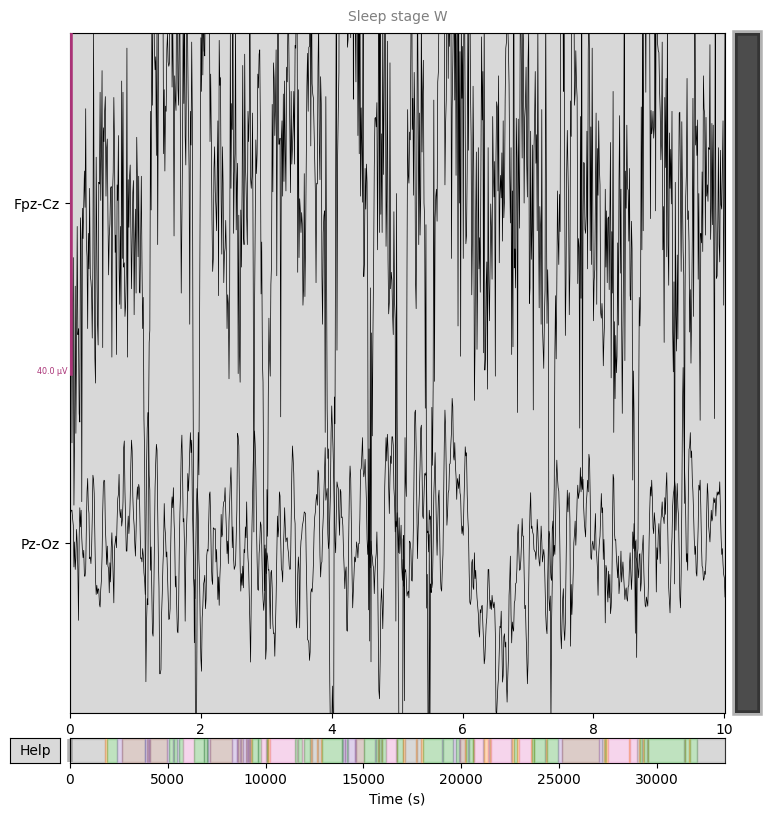

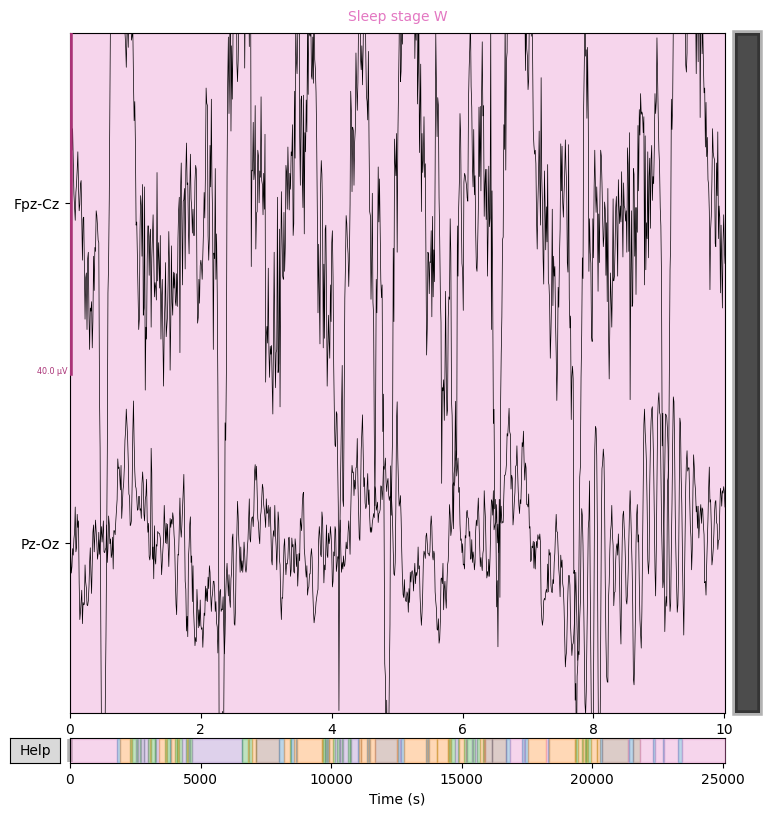

In [14]:
# Plot a recording as a sanity check
raws[1].plot();
raws[0].plot();

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 45 samples (0.450 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 30 Hz

FIR filter paramet

<ipython-input-15-90d1f3446c21>:8: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raws[0].plot_psd();
<ipython-input-15-90d1f3446c21>:8: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raws[0].plot_psd();


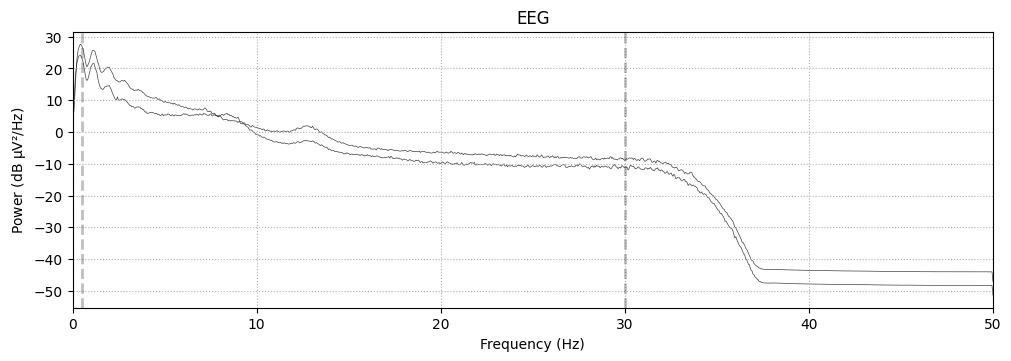

In [15]:
l_freq, h_freq = None, 30

for raw in raws:
    raw.load_data().filter(l_freq, h_freq)  # filtering happens in-place


# Plot the power spectrum of a recording as sanity check
raws[0].plot_psd();

In [16]:
# function to extract 30-s windows

def extract_epochs(raw, chunk_duration=30.):

    annotation_desc_2_event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3': 4,
        'Sleep stage 4': 4,
        'Sleep stage R': 5}

    events, _ = mne.events_from_annotations(
        raw, event_id=annotation_desc_2_event_id,
        chunk_duration=chunk_duration)

    # create a new event_id that unifies stages 3 and 4
    event_id = {
        'Sleep stage W': 1,
        'Sleep stage 1': 2,
        'Sleep stage 2': 3,
        'Sleep stage 3/4': 4,
        'Sleep stage R': 5}

    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    picks = mne.pick_types(raw.info, eeg=True, eog=True)
    epochs = mne.Epochs(raw=raw, events=events, picks=picks, preload=True,
                        event_id=event_id, tmin=0., tmax=tmax, baseline=None)

    return epochs.get_data(), epochs.events[:, 2] - 1

In [17]:
# wrap arounfd around pytorch dataset class
from torch.utils.data import Dataset, ConcatDataset

class EpochsDataset(Dataset):

    def __init__(self,epochs_data, epochs_labels, subj_nb=None, rec_nb=None, transform =None):
        assert len(epochs_data) == len(epochs_labels)
        self.epochs_data =epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform
    def __len__(self):
        return len(self.epochs_labels)
    def __getitem__(self,idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]
        if self.transform is not None:
            X = self.transform(X)
        X = torch.as_tensor(X[None, ...])
        return X, y

#Standard scaling of data

def scale(X):

    X -= np.mean(X, axis=1, keepdims=True)
    return X / np.std(X, axis=1, keepdims=True)

In [18]:

raws = [load_sleep_physionet_raw(f[0], f[1]) for f in fnames]

# If you want to test with only two datasets
raws_exc = [raws[1]]  # Remove the dataset you want to exclude
all_datasets = [EpochsDataset(*extract_epochs(raw), subj_nb=raw.info['subject_info']['id'], rec_nb=raw.info['subject_info']['rec_id'], transform=scale)
                for i, raw in enumerate(raws) if i not in raws_exc]

# Concatenate into a single dataset
dataset = ConcatDataset(all_datasets)


Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8405999  =      0.000 ... 84059.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sleepData/sleep_data/SC4012E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8549999  =      0.000 ... 85499.990 secs...
Extracting EDF parameters from /content/drive/MyDrive/sl

<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1115 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1115 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1087 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1087 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1149 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1020 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1020 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1008 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1008 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
950 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 950 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
902 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 902 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1234 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1234 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1198 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1198 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
670 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 670 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1245 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1245 events and 3000 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
827 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 827 events and 3000 original time points ...


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1012 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1012 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
969 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 969 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1271 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1271 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1127 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1127 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1053 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1053 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1130 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1130 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1103 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1103 events and 3000 original time points ...
0 bad epochs dropped


<ipython-input-16-92fba93f74ce>:30: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  return epochs.get_data(), epochs.events[:, 2] - 1


In [19]:
from sklearn.model_selection import LeavePGroupsOut


def pick_recordings(dataset, subj_rec_nbs):

    pick_idx = []
    for subj_nb, rec_nb in subj_rec_nbs:
        for i, ds in enumerate(dataset.datasets):
            if (ds.subj_nb == subj_nb) and (ds.rec_nb == rec_nb):
                pick_idx.append(i)

    remaining_idx = np.setdiff1d(
        range(len(dataset.datasets)), pick_idx)

    pick_ds = ConcatDataset([dataset.datasets[i] for i in pick_idx])
    if len(remaining_idx) > 0:
        remaining_ds = ConcatDataset(
            [dataset.datasets[i] for i in remaining_idx])
    else:
        remaining_ds = None

    return pick_ds, remaining_ds


def train_test_split(dataset, n_groups, split_by='subj_nb'):

    groups = [getattr(ds, split_by) for ds in dataset.datasets]
    train_idx, test_idx = next(
        LeavePGroupsOut(n_groups).split(X=groups, groups=groups))

    train_ds = ConcatDataset([dataset.datasets[i] for i in train_idx])
    test_ds = ConcatDataset([dataset.datasets[i] for i in test_idx])

    return train_ds, test_ds

In [20]:
# We seed the random number generators to make our splits reproducible
torch.manual_seed(103)
np.random.seed(103)

In [21]:
# Use recording 1 of subjects 0-19 as test set
test_recs = [(subj_nb, rec_nb)  #
             for subj_nb, rec_nb in zip(range(20), [1] * 10)]
test_ds, train_ds = pick_recordings(dataset, test_recs)

In [22]:
# Split remaining recordings into training and validation sets
n_subjects_valid = max(1, int(len(train_ds.datasets) * 0.2))
train_ds, valid_ds = train_test_split(train_ds, n_subjects_valid, split_by='subj_nb')

print('Number of examples in each set:')
print(f'Training: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

Number of examples in each set:
Training: 8792
Validation: 2264
Test: 9850


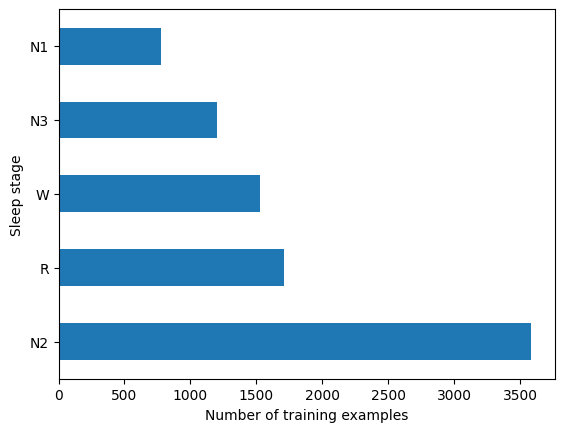

In [23]:
classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'R'}
y_train = pd.Series([y for _, y in train_ds]).map(classes_mapping)
ax = y_train.value_counts().plot(kind='barh')
ax.set_xlabel('Number of training examples');
ax.set_ylabel('Sleep stage');

In [24]:
# Computing class weight
from sklearn.utils.class_weight import compute_class_weight

train_y = np.concatenate([ds.epochs_labels for ds in train_ds.datasets])
class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
print(class_weights)

[1.14928105 2.27183463 0.49089894 1.46777963 1.0295082 ]


In [25]:
from torch import nn


class SleepStagerChambon2018(nn.Module):

    def __init__(self, n_channels, sfreq, n_conv_chs=8, time_conv_size_s=0.5,
                 max_pool_size_s=0.125, n_classes=5, input_size_s=30,
                 dropout=0.25):
        super().__init__()

        time_conv_size = int(time_conv_size_s * sfreq)
        max_pool_size = int(max_pool_size_s * sfreq)
        input_size = int(input_size_s * sfreq)
        pad_size = time_conv_size // 2
        self.n_channels = n_channels
        len_last_layer = self._len_last_layer(
            n_channels, input_size, max_pool_size, n_conv_chs)

        if n_channels > 1:
            self.spatial_conv = nn.Conv2d(1, n_channels, (n_channels, 1))

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(
                1, n_conv_chs, (1, time_conv_size), padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size)),
            nn.Conv2d(
                n_conv_chs, n_conv_chs, (1, time_conv_size),
                padding=(0, pad_size)),
            nn.ReLU(),
            nn.MaxPool2d((1, max_pool_size))
        )
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(len_last_layer, n_classes)
        )

    @staticmethod
    def _len_last_layer(n_channels, input_size, max_pool_size, n_conv_chs):
        return n_channels * (input_size // (max_pool_size ** 2)) * n_conv_chs

    def forward(self, x):

        if self.n_channels > 1:
            x = self.spatial_conv(x)
            x = x.transpose(1, 2)

        x = self.feature_extractor(x)
        return self.fc(x.flatten(start_dim=1))

In [26]:
# hyperperameters
dropout=0.75
lr=1e-3

In [27]:
sfreq = raws[0].info['sfreq']  # Sampling frequency
n_channels = raws[0].info['nchan']  # Number of channels

model = SleepStagerChambon2018(n_channels, sfreq, n_classes=5,dropout=dropout)

In [28]:
model = model.to(device)

In [29]:
from torch.utils.data import DataLoader

# Create dataloaders
train_batch_size = 128  # Important hyperparameter
valid_batch_size = 250  # Can be made as large as what fits in memory; won't impact performance
num_workers = 0  # Number of processes to use for the data loading process; 0 is the main Python process

loader_train = DataLoader(
    train_ds, batch_size=train_batch_size, shuffle=True, num_workers=num_workers)
loader_valid = DataLoader(
    valid_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)
loader_test = DataLoader(
    test_ds, batch_size=valid_batch_size, shuffle=False, num_workers=num_workers)

In [30]:
# functions to carry out our training and validation loops:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

def _do_train(model, loader, optimizer, criterion, device, metric):
    # training loop
    model.train()

    train_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = [], []
    for idx_batch, (batch_x, batch_y) in enumerate(loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.int64)

        output = model(batch_x)
        loss = criterion(output, batch_y)

        loss.backward()
        optimizer.step()

        y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
        y_true_all.append(batch_y.cpu().numpy())

        train_loss[idx_batch] = loss.item()

    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(train_loss), perf


def _validate(model, loader, criterion, device, metric):
    # validation loop
    model.eval()

    val_loss = np.zeros(len(loader))
    y_pred_all, y_true_all = [], []
    with torch.no_grad():
        for idx_batch, (batch_x, batch_y) in enumerate(loader):
            batch_x = batch_x.to(device=device, dtype=torch.float32)
            batch_y = batch_y.to(device=device, dtype=torch.int64)
            output = model.forward(batch_x)

            loss = criterion(output, batch_y)
            val_loss[idx_batch] = loss.item()

            y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
            y_true_all.append(batch_y.cpu().numpy())

    y_pred = np.concatenate(y_pred_all)
    y_true = np.concatenate(y_true_all)
    perf = metric(y_true, y_pred)

    return np.mean(val_loss), perf


def train(model, loader_train, loader_valid, optimizer, criterion, n_epochs,
          patience, device, metric=None):

    best_valid_loss = np.inf
    best_model = copy.deepcopy(model)
    waiting = 0
    history = []

    if metric is None:
        metric = balanced_accuracy_score

    print('epoch \t train_loss \t valid_loss \t train_perf \t valid_perf')
    print('-------------------------------------------------------------------')

    for epoch in range(1, n_epochs + 1):
        train_loss, train_perf = _do_train(
            model, loader_train, optimizer, criterion, device, metric=metric)
        valid_loss, valid_perf = _validate(
            model, loader_valid, criterion, device, metric=metric)
        history.append(
            {'epoch': epoch,
             'train_loss': train_loss, 'valid_loss': valid_loss,
             'train_perf': train_perf, 'valid_perf': valid_perf})

        print(f'{epoch} \t {train_loss:0.4f} \t {valid_loss:0.4f} '
              f'\t {train_perf:0.4f} \t {valid_perf:0.4f}')

        # model saving
        if valid_loss < best_valid_loss:
            print(f'best val loss {best_valid_loss:.4f} -> {valid_loss:.4f}')
            best_valid_loss = valid_loss
            best_model = copy.deepcopy(model)
            waiting = 0
        else:
            waiting += 1

        # model early stopping
        if waiting >= patience:
            print(f'Stop training at epoch {epoch}')
            print(f'Best val loss : {best_valid_loss:.4f}')
            break

    return best_model, history

In [31]:
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=lr, weight_decay=0)
criterion = CrossEntropyLoss(weight=torch.Tensor(class_weights).to(device))

In [32]:
n_epochs =11 #10
patience =11 #10
best_model, history = train(model, loader_train, loader_valid, optimizer, criterion, n_epochs, patience,
                                 device, metric=cohen_kappa_score)

epoch 	 train_loss 	 valid_loss 	 train_perf 	 valid_perf
-------------------------------------------------------------------
1 	 1.5697 	 1.4148 	 0.0461 	 0.0765
best val loss inf -> 1.4148
2 	 1.3267 	 1.0245 	 0.2640 	 0.4395
best val loss 1.4148 -> 1.0245
3 	 1.0145 	 0.8848 	 0.4560 	 0.6055
best val loss 1.0245 -> 0.8848
4 	 0.8923 	 0.7425 	 0.5409 	 0.6755
best val loss 0.8848 -> 0.7425
5 	 0.8126 	 0.7308 	 0.5872 	 0.7012
best val loss 0.7425 -> 0.7308
6 	 0.7911 	 0.7349 	 0.5907 	 0.6993
7 	 0.7705 	 0.7439 	 0.6078 	 0.6571
8 	 0.7605 	 0.6658 	 0.6154 	 0.6265
best val loss 0.7308 -> 0.6658
9 	 0.7440 	 0.6763 	 0.6205 	 0.6162
10 	 0.7301 	 0.6707 	 0.6335 	 0.6061
11 	 0.7471 	 0.7897 	 0.6153 	 0.6871


In [34]:
best_epoch_index = max(range(len(history)), key=lambda i: history[i]['valid_perf'])
best_epoch_info = history[best_epoch_index]
best_epoch_performance = best_epoch_info['valid_perf']

# Print the results
print(f"Best Epoch Index: {best_epoch_index}")
print(f"Best Validation Performance: {best_epoch_performance}")

Best Epoch Index: 4
Best Validation Performance: 0.7012272634557494


In [36]:
# Compute test performance

best_model.eval()

y_pred_all, y_true_all = [], []
for batch_x, batch_y in loader_test:
    batch_x = batch_x.to(device=device, dtype=torch.float32)
    batch_y = batch_y.to(device=device, dtype=torch.int64)
    output = model.forward(batch_x)
    y_pred_all.append(torch.argmax(output, axis=1).cpu().numpy())
    y_true_all.append(batch_y.cpu().numpy())

y_pred = np.concatenate(y_pred_all)
y_true = np.concatenate(y_true_all)
rec_ids = np.concatenate(  # indicates which recording each example comes from
    [[i] * len(ds) for i, ds in enumerate(test_ds.datasets)])

test_bal_acc = balanced_accuracy_score(y_true, y_pred)
test_kappa = cohen_kappa_score(y_true, y_pred)

# print(f'Test balanced accuracy: {test_bal_acc:0.3f}')
# print(f'Test Cohen\'s kappa: {test_kappa:0.3f}')

In [37]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(conf_mat, classes_mapping):
    ticks = [key for key in classes_mapping.keys()]
    tick_labels = classes_mapping.values()

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(conf_mat, cmap='Greens')

    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.set_xticks(ticks)
    ax.set_xticklabels(tick_labels)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion matrix')

    for i in range(len(ticks)):
        for j in range(len(ticks)):
            text = ax.text(
                j, i, conf_mat[i, j], ha='center', va='center', color='k')

    fig.colorbar(im, ax=ax, fraction=0.05, label='# examples')
    fig.tight_layout()

    return fig, ax

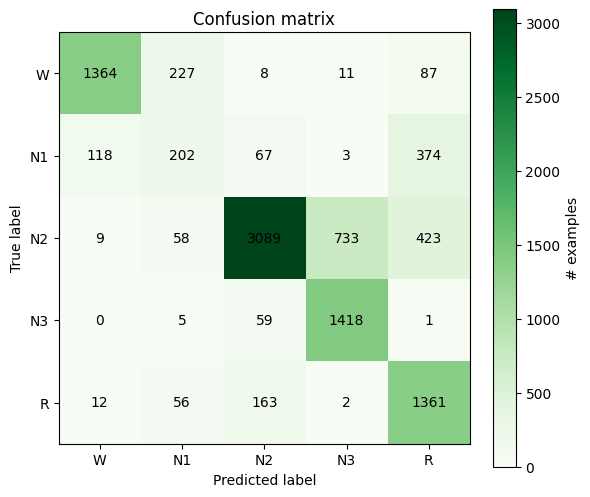

In [38]:
conf_mat = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_mat, classes_mapping);

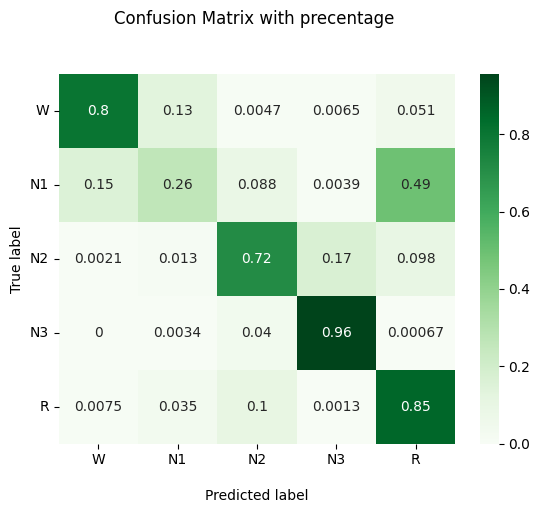

In [39]:
import seaborn as sns
x_axis_labels=["W", "N1", 'N2','N3','R']
y_axis_labels =["W", 'N1', 'N2','N3','R']

ax = sns.heatmap(conf_mat/conf_mat.sum(axis=1)[:, np.newaxis], annot=True,  cmap='Greens',xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 10)
ax.set_title('Confusion Matrix with precentage \n\n');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');


## Display the visualization of the Confusion Matrix.
plt.show()

In [40]:
from sklearn import metrics
target_names = ['W', 'N1', 'N2','N3','R']
print(metrics.classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           W       0.91      0.80      0.85      1697
          N1       0.37      0.26      0.31       764
          N2       0.91      0.72      0.80      4312
          N3       0.65      0.96      0.78      1483
           R       0.61      0.85      0.71      1594

    accuracy                           0.75      9850
   macro avg       0.69      0.72      0.69      9850
weighted avg       0.78      0.75      0.75      9850



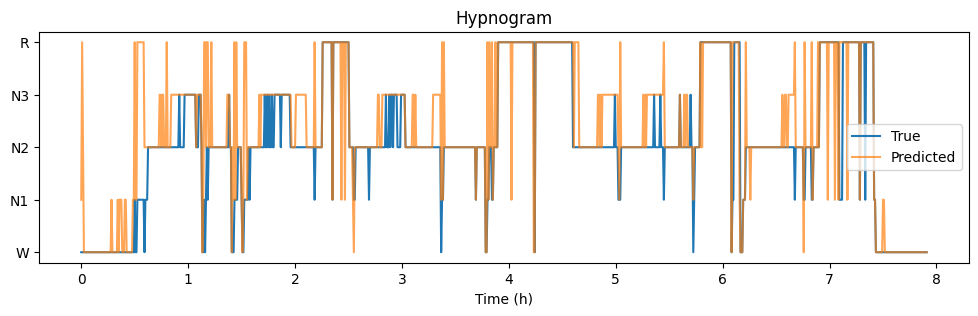

In [41]:
# Plot hypnogram for one recording

mask = rec_ids == 3  # pick a recording number

t = np.arange(len(y_true[mask])) * 30 / 3600

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t, y_true[mask], label='True')
ax.plot(t, y_pred[mask], alpha=0.7, label='Predicted')
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['W', 'N1', 'N2', 'N3', 'R'])
ax.set_xlabel('Time (h)')
ax.set_title('Hypnogram')
ax.legend();